In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from zipfile import ZipFile
import os

data_path = '/content/drive/MyDrive/H D D/gwbz3fsgp8-2'

# The `IsADirectoryError` occurred because `data_path` refers to a directory,
# not a zip file. The `zipfile.ZipFile` constructor expects a path to a .zip archive.
#
# Based on the successful execution of subsequent cells that use data from
# '/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone', it appears the dataset
# might already be extracted.
#
# Therefore, this extraction step is being skipped.
# If you still need to extract a zip file, please update `data_path` to point
# to the actual zip file (e.g., 'path/to/your/file.zip').

print(f"Skipping zip extraction: '{data_path}' is a directory.")
print("The dataset appears to be already extracted or available at another location.")

# Original problematic code (commented out):
# with ZipFile(data_path, 'r') as zip:
#     zip.extractall()
#     print('The data set has been extracted.')

Skipping zip extraction: '/content/drive/MyDrive/H D D/gwbz3fsgp8-2' is a directory.
The dataset appears to be already extracted or available at another location.


In [ ]:
!pip install split-folders

In [ ]:
import splitfolders
splitfolders.ratio(
    "/content/drive/MyDrive/H D D/gwbz3fsgp8-2",
   output="./dataset",
   seed=7,
   ratio=(0.8,0.1, 0.1)
)

Copying files: 928 files [00:26, 34.65 files/s] 


In [ ]:
import os
import math
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Activation, Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator # New import

# The `path` and `path_name` variables below are no longer directly used for data loading,
# as `splitfolders` has reorganized the data and `ImageDataGenerator` will be used.
# path = os.listdir('/content/drive/MyDrive/H D D/gwbz3fsgp8-2.keras')
# path_name = '/content/drive/MyDrive/H D D/gwbz3fsgp8-2.keras'

# --- Data Loading and Preprocessing using ImageDataGenerator ---

# Define the base path where splitfolders created the dataset
base_dataset_output_path = './dataset'
train_dir = os.path.join(base_dataset_output_path, 'train')
val_dir = os.path.join(base_dataset_output_path, 'val')
test_dir = os.path.join(base_dataset_output_path, 'test')

# Get the actual class names from the directory structure created by splitfolders
# These will be the actual folder names (e.g., 'ECG Images of Myocardial Infarction Patients (240x12=2880)')
# Sorting ensures consistent order of class indices.
classes = sorted(os.listdir(train_dir))
num_classes = len(classes)
print(f"Detected classes (actual folder names from '{train_dir}'): {classes}")
print(f"Number of classes: {num_classes}")

IMG_WIDTH, IMG_HEIGHT = 128, 128
BATCH_SIZE = 32

# Create ImageDataGenerators
# Rescale pixel values to [0, 1]. Augmentation can be added for `train_datagen` if desired.
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Optional: Print the class indices mapping for reference
print(f"Class indices mapping: {train_generator.class_indices}")

# --- Model Definition ---

# In[7]: Converging Path : Layer 1
inputs = tf.keras.layers.Input((IMG_WIDTH,IMG_HEIGHT,3))
# Remove the Lambda layer for rescaling as ImageDataGenerator already handles it
s = inputs

c1 = tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(s)
c1 = tf.keras.layers.Dropout(0.2)(c1)
c1 = tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(c1)


# Layer 2

c2 = tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.3)(c2)
c2 = tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(c2)


# Layer 3

c3 = tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(c3)


# Layer 4

c4 = tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(c4)


# Layer 5

c5 = tf.keras.layers.Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.2)(c5)
c5 = tf.keras.layers.Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c5)


# Expansive Path:
#
# Layer 1

u6 = tf.keras.layers.Conv2DTranspose(128,(2,2),strides=(2,2),padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6,c4])
c6 = tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.3)(c6)
c6 = tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c6)


# Layer 2

u7 = tf.keras.layers.Conv2DTranspose(64,(2,2),strides=(2,2),padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7,c3])
c7 = tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.3)(c7)
c7 = tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c7)


# Layer 3

u8 = tf.keras.layers.Conv2DTranspose(32,(2,2),strides=(2,2),padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8,c2])
u8 = tf.keras.layers.Dropout(0.2)(u8)
c8 = tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.2)(c8)
c8 = tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c8)


# Layer 4

u9 = tf.keras.layers.Conv2DTranspose(16,(2,2),strides=(2,2),padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9,c1])
c9 = tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.2)(c9)
c9 = tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c9)


# Layer 5

# The first Conv2D layer in this block originally used (4,(1,1)). This was likely intended
# as a final convolutional layer where '4' corresponds to the number of classes. We will ensure
# the final Dense layer uses the dynamically determined 'num_classes'.
c10 = tf.keras.layers.Conv2D(4,(1,1),activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.01))(c9)
c10 = tf.keras.layers.Dropout(0.3)(c10)
c10= tf.keras.layers.Flatten()(c10)
c12= tf.keras.layers.Dense(512,kernel_regularizer=tf.keras.regularizers.L2(0.01),activity_regularizer=tf.keras.regularizers.L1(0.01))(c10)
c12 = tf.keras.layers.Dropout(0.2)(c12)
outputs = tf.keras.layers.Dense(num_classes,activation = 'softmax')(c12) # Use num_classes for the final output layer


# In[17]:
model = tf.keras.Model(inputs=[inputs],outputs=[outputs])
# Removed sample_weight_mode='temporal' as it's not typically used for image classification
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()


# Early Stopping

# In[19]:
callbacks = [tf.keras.callbacks.ModelCheckpoint('HEART_DISEASE_DETECTION_MODEL.keras',verbose=1,save_best_only=True),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0.01,patience=20,verbose=1),
             tf.keras.callbacks.TensorBoard(log_dir='logs')]


# In[ ]: Fit the model using generators
results = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=callbacks
)

Detected classes (actual folder names from './dataset/train'): ['ECG Images of Myocardial Infarction Patients (240x12=2880)', 'ECG Images of Patient that have History of MI (172x12=2064)', 'ECG Images of Patient that have abnormal heartbeat (233x12=2796)', 'Normal Person ECG Images (284x12=3408)']
Number of classes: 4
Found 741 images belonging to 4 classes.
Found 91 images belonging to 4 classes.
Found 96 images belonging to 4 classes.
Class indices mapping: {'ECG Images of Myocardial Infarction Patients (240x12=2880)': 0, 'ECG Images of Patient that have History of MI (172x12=2064)': 1, 'ECG Images of Patient that have abnormal heartbeat (233x12=2796)': 2, 'Normal Person ECG Images (284x12=3408)': 3}


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      2,320 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │      9,248 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     36,928 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 16, 16,    │          0 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │    147,584 │ dropout_3[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 128) │          0 │ conv2d_7[0][0]  

 Total params: 35,498,152 (135.41 MB)

 Trainable params: 35,498,152 (135.41 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2446 - loss: 885.1593
Epoch 1: val_loss improved from inf to 19.20425, saving model to HEART_DISEASE_DETECTION_MODEL.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.2454 - loss: 863.8138 - val_accuracy: 0.2500 - val_loss: 19.2043
Epoch 2/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.1875 - loss: 24.4159

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss improved from 19.20425 to 17.61929, saving model to HEART_DISEASE_DETECTION_MODEL.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 218ms/step - accuracy: 0.1875 - loss: 24.4159 - val_accuracy: 0.3125 - val_loss: 17.6193
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 630ms/step - accuracy: 0.2377 - loss: 22.8841
Epoch 3: val_loss improved from 17.61929 to 15.97944, saving model to HEART_DISEASE_DETECTION_MODEL.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 807ms/step - accuracy: 0.2376 - loss: 22.8379 - val_accuracy: 0.0156 - val_loss: 15.9794
Epoch 4/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.2500 - loss: 19.4812
Epoch 4: val_loss improved from 15.97944 to 15.94864, saving model to HEART_DISEASE_DETECTION_MODEL.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 227ms/step - accuracy: 0.2500 - loss: 19.4812 - val_accuracy: 0.0156 - val_loss: 15.9486
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 601ms/step - accuracy: 0.2468 - loss: 19.1565
Epoch 5: val_loss improved from 15.94864 to 15.14230, savin

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 14: val_loss improved from 12.85046 to 12.82817, saving model to HEART_DISEASE_DETECTION_MODEL.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 472ms/step - accuracy: 0.2500 - loss: 13.3607 - val_accuracy: 0.0156 - val_loss: 12.8282
Epoch 15/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 635ms/step - accuracy: 0.3007 - loss: 13.1009
Epoch 15: val_loss improved from 12.82817 to 12.03121, saving model to HEART_DISEASE_DETECTION_MODEL.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 22s 967ms/step - accuracy: 0.3010 - loss: 13.0926 - val_accuracy: 0.0156 - val_loss: 12.0312
Epoch 16/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.0938 - loss: 12.5413
Epoch 16: val_loss improved from 12.03121 to 12.00218, saving model to HEART_DISEASE_DETECTION_MODEL.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 14s 631ms/step - accuracy: 0.0938 - loss: 12.5413 - val_accuracy: 0.0156 - val_loss: 12.0022
Epoch 17/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 635ms/step - accuracy: 0.3121 - loss: 12.2652
Epoch 17: val_loss improved from 12.00218 to 11.322

In [ ]:
acc = results.history['accuracy']
val_acc = results.history['val_accuracy']
epochs = range(len(acc))
fig = plt.figure(figsize=(10,7))
plt.plot(epochs,acc,'r',label="Training Accuracy")
plt.plot(epochs,val_acc,'b',label="Validation Accuracy")
plt.legend(loc='upper left')
plt.show()

NameError: name 'results' is not defined

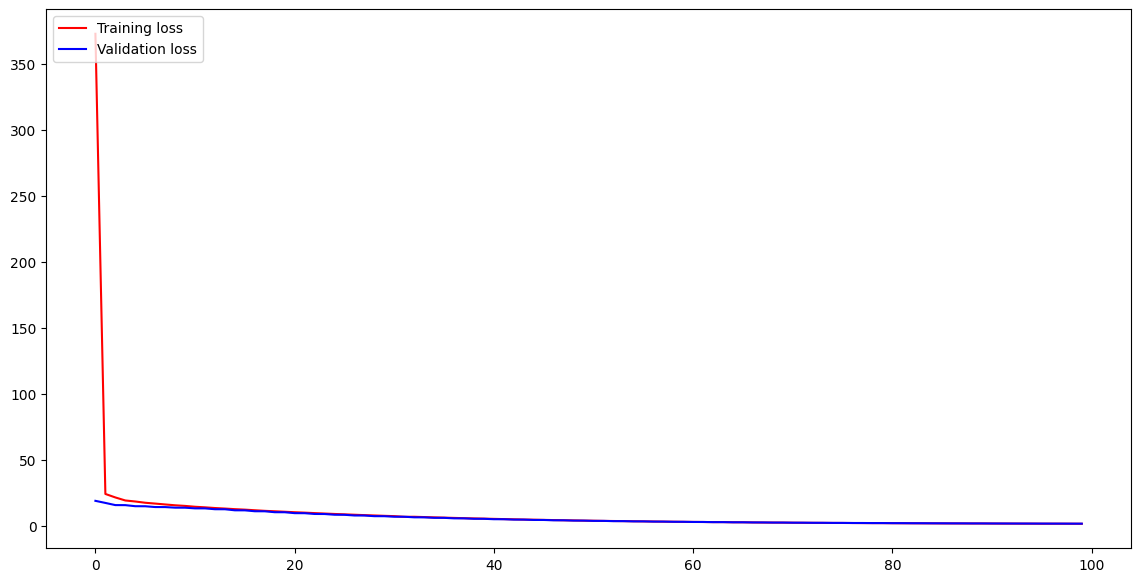

In [ ]:
loss = results.history['loss']
val_loss = results.history['val_loss']
epochs = range(len(loss))
fig = plt.figure(figsize=(14,7))
plt.plot(epochs,loss,'r',label="Training loss")
plt.plot(epochs,val_loss,'b',label="Validation loss")
plt.legend(loc='upper left')
plt.show()

In [ ]:
score = model.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 731ms/step - accuracy: 0.1510 - loss: 1.8858
Test loss: 1.8517168760299683
Test accuracy: 0.3020833432674408


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf

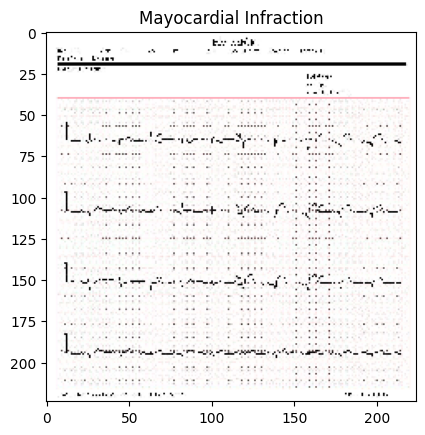

In [ ]:
from tensorflow.keras.utils import load_img,img_to_array
c = load_img('/content/drive/MyDrive/H D D/gwbz3fsgp8-2/ECG Images of Myocardial Infarction Patients (240x12=2880)/MI(100).jpg',target_size=(224,224))
plt.imshow(c)
plt.title('Mayocardial Infraction')
plt.show()

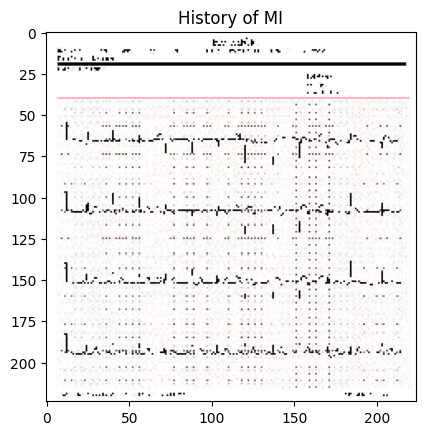

In [ ]:
s = load_img('/content/drive/MyDrive/H D D/gwbz3fsgp8-2/ECG Images of Patient that have History of MI (172x12=2064)/PMI(10).jpg',target_size=(224,224))
plt.imshow(s)
plt.title('History of MI')
plt.show()

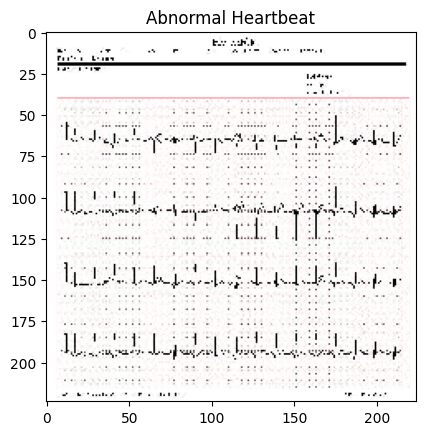

In [ ]:
n = load_img('/content/drive/MyDrive/H D D/gwbz3fsgp8-2/ECG Images of Patient that have abnormal heartbeat (233x12=2796)/HB(100).jpg',target_size=(224,224))
plt.imshow(n)
plt.title('Abnormal Heartbeat')
plt.show()

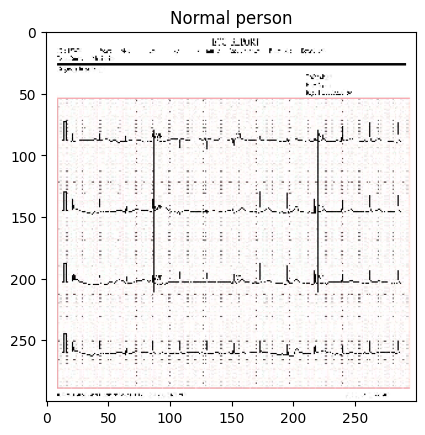

In [ ]:
t = load_img('/content/drive/MyDrive/H D D/gwbz3fsgp8-2/Normal Person ECG Images (284x12=3408)/Normal(102).jpg',target_size=(300,300))
plt.imshow(t)
plt.title('Normal person')
plt.show()

Text(0.5, 1.0, 'normal')

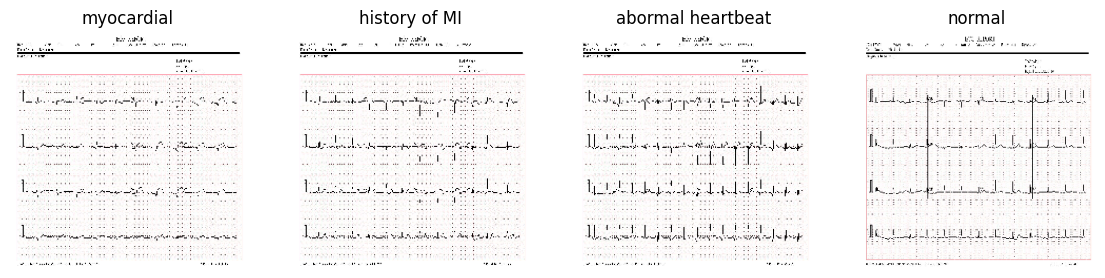

In [ ]:
fig = plt.figure(figsize=(14,7))
# plt.grid=False
fig.add_subplot(1, 4, 1)
plt.axis('off')
plt.imshow(c)
plt.title('myocardial')
# _______________________________
fig.add_subplot(1, 4, 2)
plt.axis('off')
plt.imshow(s)
plt.title('history of MI')
# _______________________________
fig.add_subplot(1, 4, 3)
plt.axis('off')
plt.imshow(n)
plt.title('abormal heartbeat')
# _______________________________
fig.add_subplot(1, 4, 4)
plt.axis('off')
plt.imshow(t)
plt.title('normal')

In [ ]:
import cv2

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

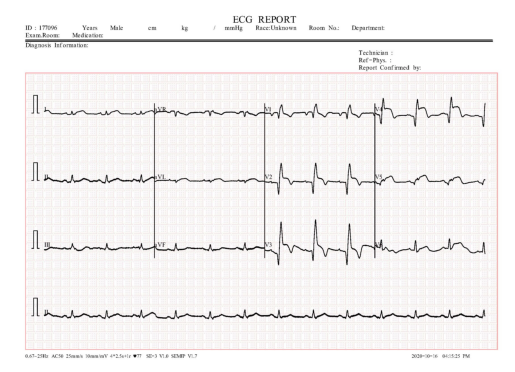

In [ ]:
orig_img = cv2.imread("/content/drive/MyDrive/H D D/gwbz3fsgp8-2/ECG Images of Myocardial Infarction Patients (240x12=2880)/MI(106).jpg", 1)  # 1 indicates color image
# OpenCV uses BGR while Matplotlib uses RGB format

plt.imshow(cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

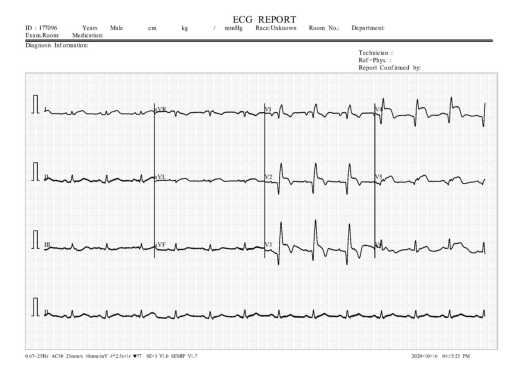

In [ ]:
gray_img = cv2.cvtColor( orig_img, cv2.COLOR_BGR2GRAY )
plt.imshow(gray_img,cmap='gray')
plt.axis('off')
plt.show()

Threshold limit: 140.0


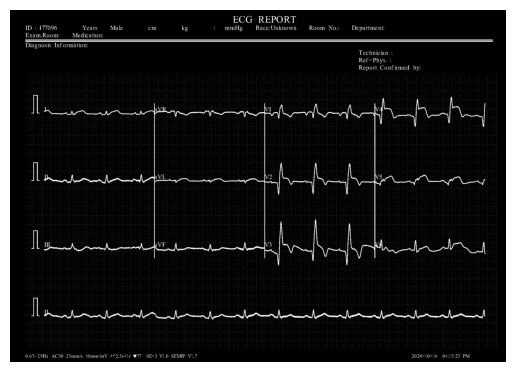

In [ ]:
ret, thresh = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
print("Threshold limit: " + str(ret))

plt.axis('off')
plt.imshow(thresh, cmap = 'gray')

In [ ]:
kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations = 2)

# sure background area
sure_bg = cv2.dilate(opening, kernel, iterations = 3)

# sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

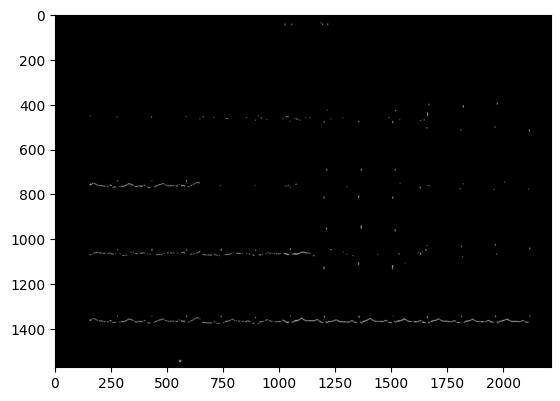

In [ ]:
plt.imshow(dist_transform, cmap = 'gray')

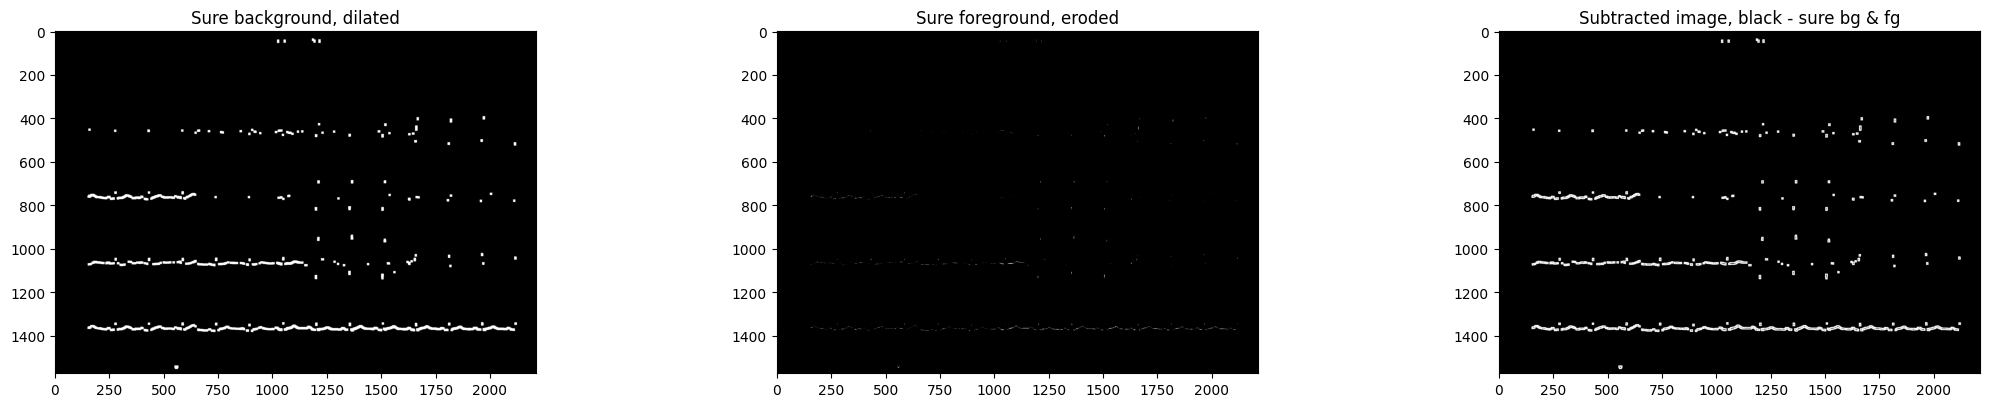

In [ ]:
fig = plt.figure(figsize = (20, 10)) # to change figsize
plt.subplot(131)
plt.imshow(sure_bg, cmap = 'gray')
plt.title('Sure background, dilated')

plt.subplot(132)
plt.imshow(sure_fg, cmap = 'gray')
plt.title('Sure foreground, eroded')

plt.subplot(133)
plt.imshow(unknown, cmap = 'gray')
plt.title('Subtracted image, black - sure bg & fg')
plt.tight_layout()

plt.subplots_adjust(wspace = 0.5)

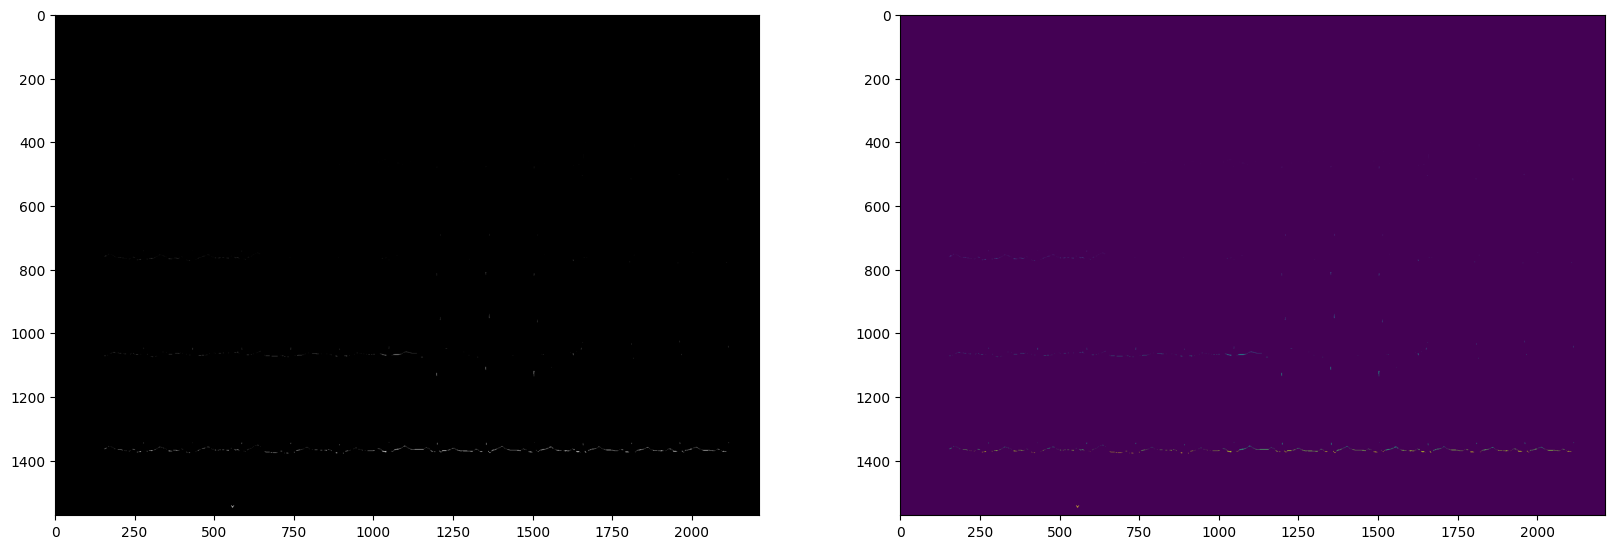

In [ ]:
ret, markers = cv2.connectedComponents(sure_fg)

markers = markers + 1

markers[unknown==255] = 0

fig = plt.figure(figsize = (20, 10)) # to change figsize
plt.subplot(121)
plt.imshow(markers, cmap = 'gray')
plt.subplot(122)
plt.imshow(markers)

In [ ]:
markers = cv2.watershed(orig_img, markers)
orig_img[markers == -1] = [0, 255,0]

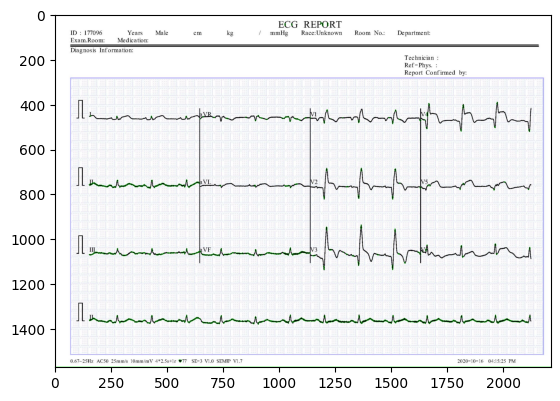

In [ ]:
plt.imshow(orig_img)